# Permutation-invariant model

In [1]:
import numpy as np
import torch
import pytorch_lightning as L

from torch.utils.data import DataLoader
from models import GPT2Model

#############################################
N = 30000
qcd_run_id = "44435059d9624828a240bc94a32f7214"
tops_run_id = "e3e5072962ba4dde81b96c7090da422e"
#############################################

path = "/home/df630/SyntheticJets/experiments/results/comet/synthetic-jets"

qcd_gpt2 = GPT2Model.load_from_checkpoint(f"{path}/{qcd_run_id}/checkpoints/best.ckpt")
tops_gpt2 = GPT2Model.load_from_checkpoint(f"{path}/{tops_run_id}/checkpoints/best.ckpt")



Lightning automatically upgraded your loaded checkpoint from v1.9.5 to v2.5.0.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint experiments/results/comet/synthetic-jets/44435059d9624828a240bc94a32f7214/checkpoints/best.ckpt`


INFO: vocab_size: 600, start_token_id: 600


Lightning automatically upgraded your loaded checkpoint from v1.9.5 to v2.5.0.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint experiments/results/comet/synthetic-jets/e3e5072962ba4dde81b96c7090da422e/checkpoints/best.ckpt`


INFO: vocab_size: 600, start_token_id: 600


## Jet generation

In [2]:
prompts = torch.full((N, 1), qcd_gpt2.start_token, dtype=torch.long, device=qcd_gpt2.device)
prompt_dataloadeer = DataLoader(prompts, batch_size=1024, shuffle=False)

generator = L.Trainer(accelerator="gpu", devices=1)
qcd_jet_seq = generator.predict(qcd_gpt2, dataloaders=prompt_dataloadeer)
qcd_jet_seq = torch.cat(qcd_jet_seq, dim=0)
qcd_jet_bin = qcd_gpt2.synthetic_jets.tokens_to_bins(qcd_jet_seq) 



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/home/df630/.conda/envs/markov_bridges/lib/python3.10/site-packages/pytorch_lightning-2.5.0.post0-py3.10.egg/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [3]:
prompts = torch.full((N, 1), tops_gpt2.start_token, dtype=torch.long, device=tops_gpt2.device)
prompt_dataloadeer = DataLoader(prompts, batch_size=1024, shuffle=False)

generator = L.Trainer(accelerator="gpu", devices=1)
tops_jet_seq = generator.predict(tops_gpt2, dataloaders=prompt_dataloadeer)
tops_jet_seq = torch.cat(tops_jet_seq, dim=0)
tops_jet_bin = tops_gpt2.synthetic_jets.tokens_to_bins(tops_jet_seq) 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [4]:
from synthetic_data import SyntheticJets
from utils import kin_plots, ordered_z_plots

qcd = SyntheticJets(shape_param=qcd_gpt2.shape, 
                    scale_param=qcd_gpt2.scale, 
                    bins_z= qcd_gpt2.bins_z,
                    bins_phi=qcd_gpt2.bins_phi,
                    z_order=True,
                    tokenize=True,
                    )

toy_qcd  = qcd.sample(N=N)
toy_qcd = qcd.tokens_to_bins(toy_qcd)

tops = SyntheticJets(shape_param=tops_gpt2.shape, 
                    scale_param=tops_gpt2.scale, 
                    bins_z= tops_gpt2.bins_z,
                    bins_phi=tops_gpt2.bins_phi,
                    z_order=True,
                    tokenize=True,
                    )

toy_tops  = tops.sample(N=N)
toy_tops = tops.tokens_to_bins(toy_tops)

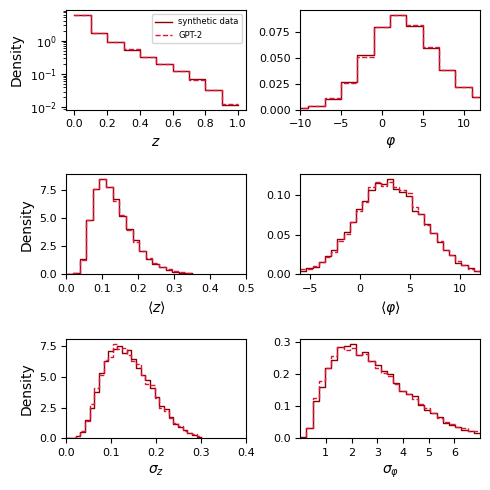

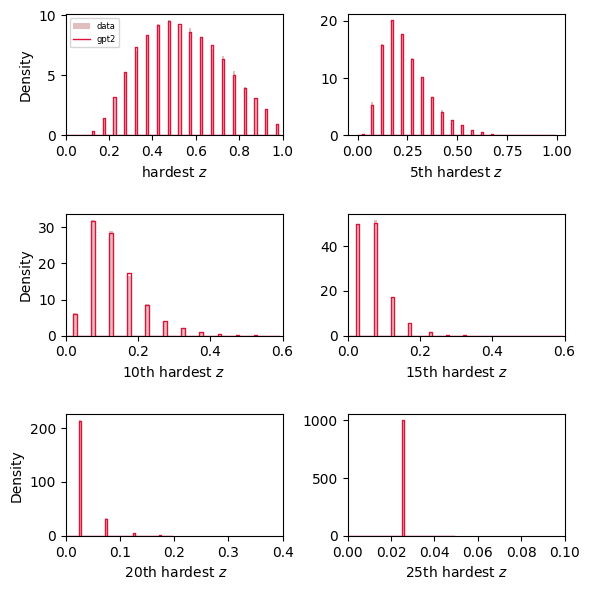

In [5]:
kin_plots(toy_qcd, qcd_jet_bin, "plots/qcd_kin.png")
ordered_z_plots(toy_qcd, qcd_jet_bin)

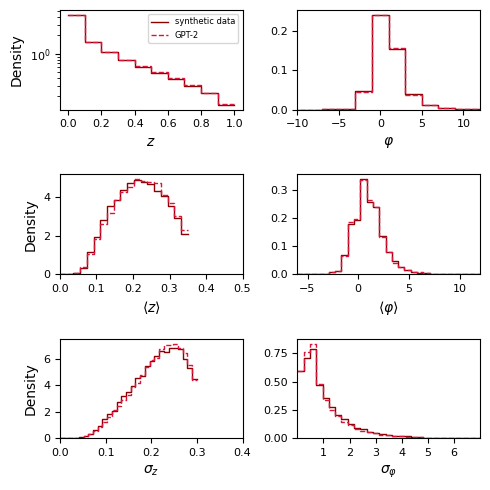

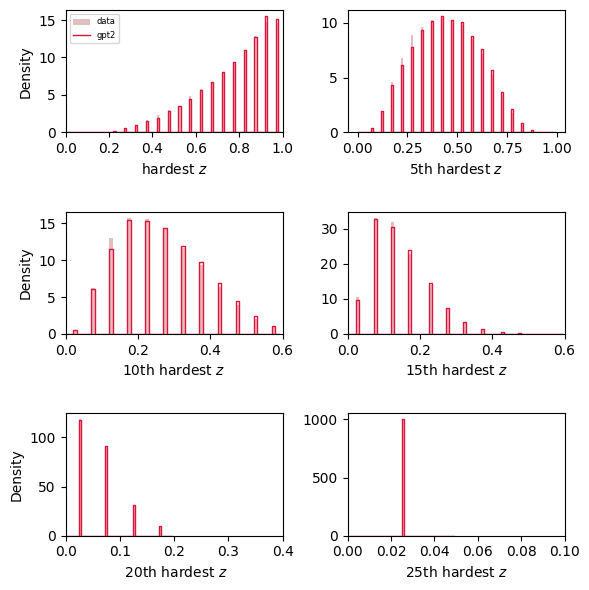

In [6]:
kin_plots(toy_tops, tops_jet_bin, "plots/tops_kin.png")
ordered_z_plots(toy_tops, tops_jet_bin)

## log-likelihood ratio

<Axes: ylabel='Count'>

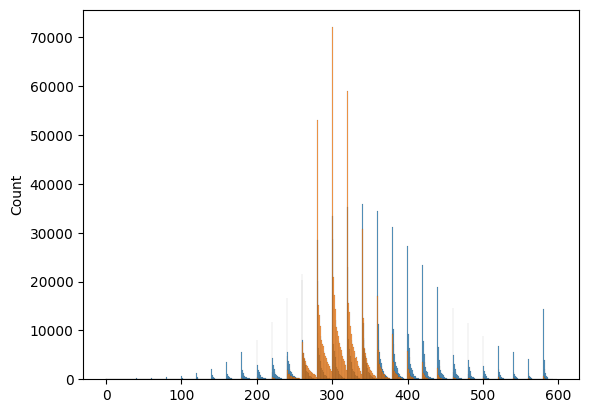

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(qcd_jet_seq.flatten(),discrete=True)
sns.histplot(tops_jet_seq.flatten(), discrete=True)


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import roc_curve, auc


qcd_logp_on_qcd = qcd_gpt2.log_probs(qcd_jet_seq, batch_size=1024)
qcd_logp_on_tops = qcd_gpt2.log_probs(tops_jet_seq, batch_size=1024)
tops_logp_on_qcd = tops_gpt2.log_probs(qcd_jet_seq, batch_size=1024)
tops_logp_on_tops = tops_gpt2.log_probs(tops_jet_seq, batch_size=1024)

def ROC(LLR_bckg, LLR_sig, label):
    """
    Compute ROC curve and AUC
    """

    scores = np.concatenate([LLR_sig, LLR_bckg])
    labels = np.concatenate([np.ones(LLR_bckg.shape[0]), np.zeros(LLR_bckg.shape[0])])

    fpr, tpr, thresholds = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)

    plt.plot(tpr, 1 / fpr, label=f"{label} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("signal efficiency")
    plt.ylabel("background rejection")
    plt.title("ROC curve")
    plt.legend()
    plt.yscale("log")

/tmp/ipykernel_2223740/1501931543.py:23: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr, 1 / fpr, label=f"{label} (AUC = {roc_auc:.2f})")
/tmp/ipykernel_2223740/1501931543.py:23: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr, 1 / fpr, label=f"{label} (AUC = {roc_auc:.2f})")


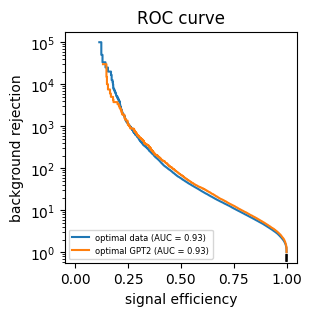

In [9]:

LLR_qcd = qcd_logp_on_tops - tops_logp_on_tops     
LLR_tops = qcd_logp_on_qcd - tops_logp_on_qcd  

optimal_LLR_qcd = np.nan_to_num(np.load("data/bkg_LLR.npy"), nan=0.0)
optimal_LLR_tops = np.nan_to_num(np.load("data/sig_LLR.npy"), nan=0.0)

plt.figure(figsize=(3, 3))
ROC(optimal_LLR_qcd, optimal_LLR_tops, "optimal data")
ROC(LLR_qcd, LLR_tops, "optimal GPT2")
plt.legend(fontsize=6, loc="lower left")
plt.show()


In [5]:
import torch
import numpy as np

def batch_row_shuffle(X: torch.Tensor) -> torch.Tensor:
    """
    Given X of shape (N, D, 2), return X_shuf where each subtensor X[n]
    has its D rows independently shuffled in a random order.
    """
    N, D = X.shape
    rand = torch.rand(N, D, device=X.device)
    perm = rand.argsort(dim=1)             # shape: (N, D)
    batch_idx = torch.arange(N, device=X.device).unsqueeze(1)  # shape: (N, 1)
    X_shuf = X[batch_idx, perm]         # shape: (N, D, 2)
    
    return torch.tensor(X_shuf)


def degenerate_row_shuffle(X: np.ndarray, Y: np.ndarray) -> np.ndarray:
    """
    Return a shuffled copy of Y, where for each 0 <= n < N:
      • We look at X[n,:,0], find values that occur >1 time,
      • For each duplicated value v, we randomly permute just those row-indices
        in Y[n] corresponding to X[n,:,0] == v.
    X itself is left intact.
    
    Parameters
    ----------
    X : np.ndarray, shape (N, D, 2)
        Reference tensor whose duplicate-first-column groups determine shuffles.
    Y : np.ndarray, shape (N, D, ...)
        Tensor to be shuffled in the same “groups” found in X.
    
    Returns
    -------
    Y_shuf : np.ndarray, same shape as Y
        A copy of Y where rows within each duplicated-first-column group
        in X have been randomly permuted.
    """
    # sanity check
    if X.shape[0] != Y.shape[0] or X.shape[1] != Y.shape[1]:
        raise ValueError("X and Y must have the same first two dimensions (N, D).")
    
    Y_shuf = Y.copy()
    N, D = X.shape[:2]

    for n in range(N):
        first_col = X[n, :, 0]
        vals, counts = np.unique(first_col, return_counts=True)
        dup_vals = vals[counts > 1]

        for v in dup_vals:
            idxs = np.nonzero(first_col == v)[0]    # e.g. array([i1, i2, ..., ik])
            rows = Y[n, idxs].copy()               # grab the corresponding rows in Y
            perm = np.random.permutation(len(idxs)) # random order of [0..k-1]
            Y_shuf[n, idxs] = rows[perm]           # apply the shuffle

    return torch.tensor(Y_shuf)

qcd_jet_seq_shuff = batch_row_shuffle(X=qcd_jet_seq)
qcd_jet_seq_degshuff = degenerate_row_shuffle(X=qcd_gpt2.synthetic_jets.tokens_to_bins(qcd_jet_seq), Y=qcd_jet_seq.numpy())




/tmp/ipykernel_2231515/2866763015.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(X_shuf)


In [6]:
qcd_jet_seq_shuff[0], qcd_jet_seq_degshuff[0], qcd_jet_seq[0]

(tensor([500, 420, 480, 460, 343, 486, 480, 400, 400, 465, 320, 443, 364, 460,
         463, 340, 501, 470, 301, 481, 441, 440, 403, 553, 368, 480, 444, 420,
         361, 507]),
 tensor([553, 470, 368, 507, 486, 465, 364, 444, 403, 443, 343, 463, 481, 361,
         441, 301, 501, 420, 460, 320, 480, 440, 460, 480, 400, 400, 420, 340,
         500, 480]),
 tensor([553, 470, 368, 507, 486, 465, 364, 444, 443, 403, 463, 343, 301, 481,
         441, 361, 501, 460, 460, 320, 400, 500, 480, 340, 480, 420, 400, 480,
         440, 420]))

In [7]:
logp = qcd_gpt2.log_probs(qcd_jet_seq, batch_size=1024)
logp_shuff = qcd_gpt2.log_probs(qcd_jet_seq_shuff, batch_size=1024)
logp_degenerate_shuff = qcd_gpt2.log_probs(qcd_jet_seq_degshuff, batch_size=1024)

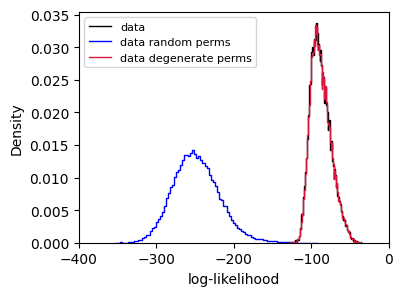

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

plt.figure(figsize=(4,3))
sns.histplot(logp, bins=100, color='k', fill=False, lw=1, label='data', element='step', stat='density')
sns.histplot(logp_shuff, bins=100, color='blue', fill=False, lw=1, label='data random perms', element='step', stat='density')
sns.histplot(logp_degenerate_shuff, bins=100, color='crimson', fill=False, lw=1, label='data degenerate perms', element='step', stat='density')
plt.xlabel(r'log-likelihood')
plt.xlim(-400, 0)
plt.ylabel('Density')
# plt.yscale('log')
plt.legend(loc='upper left', fontsize=8)
# plt.savefig('toy_LLR.png', dpi=300, bbox_inches='tight')
plt.show()

In [20]:
import torch
X = tops_jet_seq[0]
idx = torch.randperm(X.shape[0])
X_permuted = X[idx]

In [113]:
qcd_gpt2.per_token_preds(X, device=qcd_gpt2.device)
qcd_gpt2.per_token_preds(X_permuted, device=qcd_gpt2.device)

(tensor([331, 582, 343, 343, 300, 580, 325, 320, 320, 324, 323, 322, 323, 322,
         320, 320, 322, 325, 320, 321, 321, 320, 321, 320, 320, 320, 320, 320,
         320, 320]),
 tensor([ -8.9798, -11.8014,  -3.2757, -11.8173, -13.6564, -10.3707, -12.4275,
          -7.8250,  -8.2643,  -1.2716,  -3.0228, -10.9409,  -1.0720, -12.4610,
          -1.9197, -13.1726, -10.5273,  -4.0487, -11.8954, -15.6542,  -1.3532,
         -16.8285,  -1.0166, -16.5815,  -9.9165,  -4.6892,  -4.5138,  -3.1022,
         -16.7351,  -6.2124]))

In [22]:
X_permuted, X

(tensor([322, 323, 323, 320, 333, 325, 337, 332, 324, 324, 322, 323, 323, 329,
         320, 323, 327, 320, 321, 338, 320, 356, 320, 337, 309, 329, 322, 340,
         333, 331]),
 tensor([338, 337, 337, 356, 333, 333, 332, 331, 329, 309, 329, 327, 325, 324,
         324, 323, 323, 323, 323, 323, 322, 322, 322, 321, 320, 340, 320, 320,
         320, 320]))

In [136]:
toy_tops

array([[[ 0.975,  0.5  ],
        [ 0.975,  0.5  ],
        [ 0.875,  0.5  ],
        ...,
        [ 0.025,  0.5  ],
        [ 0.025,  0.5  ],
        [ 0.025,  0.5  ]],

       [[ 0.875, -0.5  ],
        [ 0.825,  0.5  ],
        [ 0.775, -0.5  ],
        ...,
        [ 0.025, -0.5  ],
        [ 0.025, -0.5  ],
        [ 0.025,  1.5  ]],

       [[ 0.675,  1.5  ],
        [ 0.525,  0.5  ],
        [ 0.525, -0.5  ],
        ...,
        [ 0.025,  0.5  ],
        [ 0.025, -2.5  ],
        [ 0.025, -0.5  ]],

       ...,

       [[ 0.675,  1.5  ],
        [ 0.425, -0.5  ],
        [ 0.375, -0.5  ],
        ...,
        [ 0.025,  0.5  ],
        [ 0.025,  1.5  ],
        [ 0.025,  0.5  ]],

       [[ 0.775,  0.5  ],
        [ 0.625,  0.5  ],
        [ 0.425,  0.5  ],
        ...,
        [ 0.025,  0.5  ],
        [ 0.025,  1.5  ],
        [ 0.025, -0.5  ]],

       [[ 0.625,  0.5  ],
        [ 0.525,  0.5  ],
        [ 0.475, -0.5  ],
        ...,
        [ 0.025, -0.5  ],
        [ 0.025

In [ ]:
toy_tops

In [103]:
qcd_ = SyntheticJets(shape_param=tops_gpt2.shape, 
                    scale_param=tops_gpt2.scale, 
                    bins_z= tops_gpt2.bins_z,
                    bins_phi=tops_gpt2.bins_phi,
                    z_order=True,
                    tokenize=False,
                    )

test  = qcd_.sample(N=N)


In [104]:
test[0]

array([[8.81760605e-01, 5.73525536e-02],
       [8.48529366e-01, 4.45093289e-02],
       [7.28144822e-01, 3.78025152e-02],
       [7.16815694e-01, 5.44498943e-02],
       [5.26406635e-01, 6.22415910e-02],
       [4.62381959e-01, 5.67096632e-02],
       [3.75895550e-01, 5.17488620e-02],
       [3.36726123e-01, 5.23732932e-02],
       [2.87254827e-01, 4.80418978e-02],
       [2.84279653e-01, 5.51728809e-02],
       [2.54990920e-01, 5.73797770e-02],
       [2.29356299e-01, 4.77523223e-02],
       [1.53499919e-01, 5.55423082e-02],
       [1.37164218e-01, 4.89408803e-02],
       [1.35586323e-01, 4.83446285e-02],
       [1.35367829e-01, 5.30461049e-02],
       [9.96994265e-02, 5.56098494e-02],
       [9.33599620e-02, 5.55680554e-02],
       [5.44791887e-02, 4.49773697e-02],
       [4.01349349e-02, 5.17956237e-02],
       [3.32603069e-02, 6.10077173e-02],
       [2.63708120e-02, 3.36174011e-02],
       [1.44076353e-02, 4.83027610e-02],
       [1.29992930e-02, 5.23780782e-02],
       [8.626050

(-20.0, 20.0)

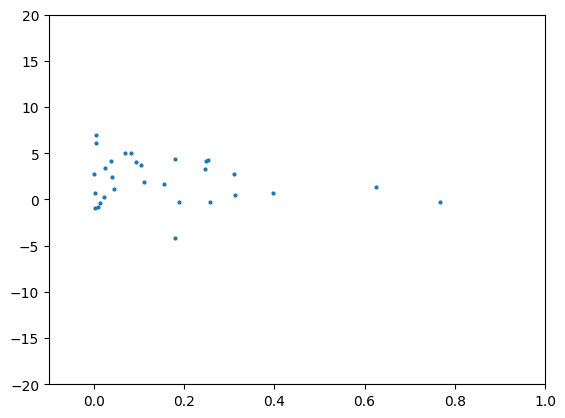

In [112]:
n=30
plt.scatter(x=test[n][...,0], y=test[n][...,1], s=4)
plt.xlim(-0.1, 1)
plt.ylim(-20, 20)
# plt.grid()


In [52]:

toy_jet = torch.tensor([211, 210, 209, 226, 205, 205, 224, 244, 204, 184, 224, 223, 263, 222,
        221, 201, 201, 241, 221, 221, 201, 221, 220, 220, 180, 220, 200, 200,
        240, 200])
log_probs, preds = compute_token_log_probs(qcd_gpt2, toy_jet)

print("Tokens      :", toy_jet.numpy())
print("Predictions :", preds.numpy())
print("Log probs   :", log_probs.numpy())

Tokens      : [211 210 209 226 205 205 224 244 204 184 224 223 263 222 221 201 201 241
 221 221 201 221 220 220 180 220 200 200 240 200]
Predictions : [218 210 209 208 206 205 205 204 204 203 203 203 203 223 222 221 221 221
 221 221 220 220 220 220 220 220 220 220 220 220]
Log probs   : [-4.1843553 -2.3353882 -2.0094762 -4.0244117 -1.845769  -1.4440348
 -2.1380384 -2.7716331 -1.6390612 -2.707499  -2.4001026 -1.5924855
 -4.4711094 -1.8764718 -2.9722786 -1.2067927 -1.2032279 -2.1247635
 -1.4122312 -1.6075282 -1.9477379 -2.021817  -1.4256278 -1.0526438
 -2.3421159 -1.0998387 -1.1810856 -1.1272875 -1.773839  -1.2054561]


In [11]:
shuffled = qcd_seq[0][torch.randperm(len(qcd_seq[0]))]
log_probs_shuffled, _ = compute_token_log_probs(qcd_gpt2, shuffled)
print("Total log p (original) :", log_probs.sum().item())
print("Total log p (shuffled) :", log_probs_shuffled.sum().item())



Total log p (original) : -61.14411163330078
Total log p (shuffled) : -188.78878784179688


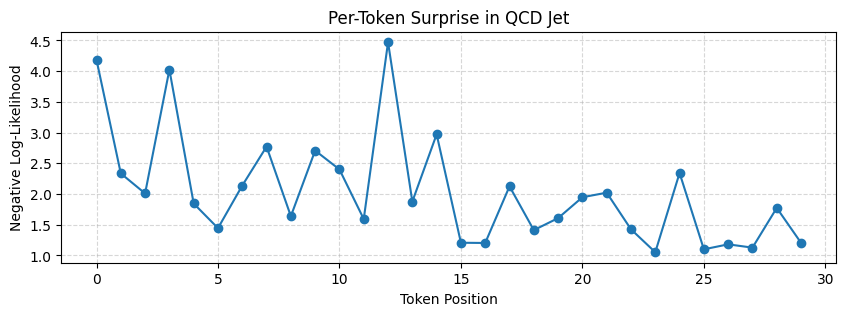

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 3))
plt.plot(-log_probs.numpy(), marker="o")
plt.xlabel("Token Position")
plt.ylabel("Negative Log-Likelihood")
plt.title("Per-Token Surprise in QCD Jet")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

In [20]:
def token_id(i,j):
    return i+30*j

In [33]:
token_id(8,9), token_id(11,4)

(278, 131)

In [43]:
30*7 + 0, 30*7 + 1

(210, 211)

# Fourier Transforms

In [1]:
! pip install finufft             # CPU NUFFT (OpenMP+FFTW)  :contentReference[oaicite:0]{index=0}

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.9 MB/s eta 0:00:00


In [2]:
import numpy as np
N, D = 100_000, 10

sig = np.random.normal(size=(N, D))
bg  = np.random.normal(size=(N, D))
data = np.vstack([sig, bg])               # shape (2N, D)

# analytic 1-D log-density:  log N(0,1)(x) = –½ x² – ½ log(2π)
logp_components = -0.5 * data**2 - 0.5*np.log(2*np.pi)
logp_total      = logp_components.sum(axis=1)          # shape (2N,)

# choose *which* x-coordinates are the sample points for the NUFFT:
x = data.ravel()                       #  flatten ALL 20×10⁴ coordinates
f = (-0.5*x**2 - 0.5*np.log(2*np.pi))  #  same shape a

In [3]:
x_min, x_max = x.min(), x.max()
x_scaled = (x - x_min)/(x_max - x_min) * (2*np.pi) - np.pi

In [29]:
import finufft

M   = 100        # number of output Fourier modes (≈ 2N is a good rule-of-thumb)
eps = 1e-15          # target relative error (double precision limit)

f_cplx = f.astype(np.complex64)
Fk = finufft.nufft1d1(x_scaled.astype(np.float32), f_cplx, M, eps=1e-6)

# Fk  = finufft.nufft1d1(x_scaled, f, M, eps=eps)   # complex128 array
k    = np.fft.fftfreq(M, 1/M) * np.pi * (x_max - x_min)/2   # un-scale wavenumbers

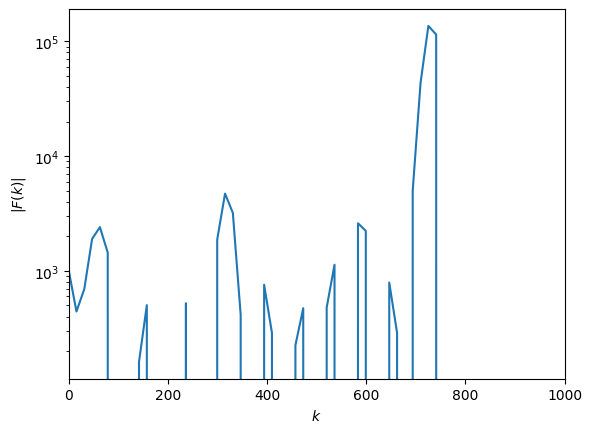

In [30]:
import matplotlib.pyplot as plt
plt.semilogy(k, Fk.real, label='real part')
plt.xlabel(r'$k$')
plt.ylabel(r'$|F(k)|$')
plt.xlim(0, 1000)
plt.show()


In [37]:
data.shape, sig.shape

((200000, 10), (100000, 10))

In [39]:
# ---------- synthetic data ---------- #
N, D = 100_000, 10
sig = np.random.normal(size=(N, D))
bg  = np.random.normal(size=(N, D))
data = np.vstack([sig, bg])

# 1-D projection: flatten all coordinates
# x = data.ravel()                               # shape (2N*D,)
f = (-0.5 * data**2 - 0.5 * np.log(2*np.pi)).sum(1)      # analytic log-density, real values
f.shape

(200000,)

In [83]:
len(x)

2000000

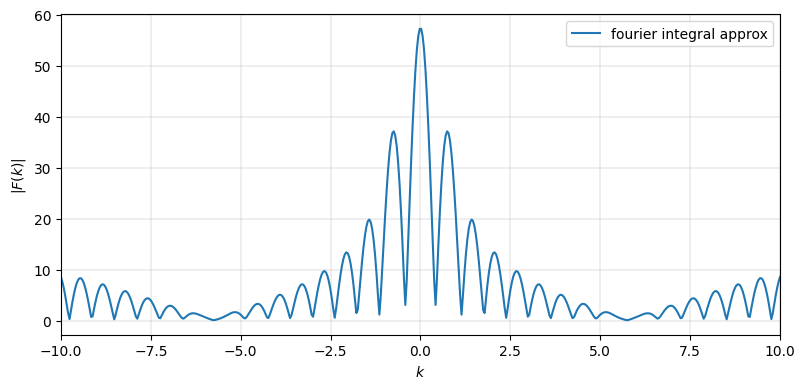

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# ---------- synthetic data ---------- #
N, D = 100_000, 10
sig = np.random.normal(size=(N, D))
bg  = np.random.normal(size=(N, D))
data = np.vstack([sig, bg])

x = data.ravel()                               # shape (2N*D,)
logp = -0.5 * x**2 - 0.5 * np.log(2*np.pi)     # analytic log-density, real values
# logp =np.exp(-x**2) / np.sqrt(2*np.pi)  # analytic log-density, real values
# ---------- Voronoi / trapezoidal weights on the subset ---------- #
idx          = np.argsort(x)
x_sorted     = x[idx]
dx_sorted     = np.empty_like(x_sorted)

dx_sorted[1:-1] = 0.5 * (x_sorted[2:] - x_sorted[:-2])
dx_sorted[0]    = 0.5 * (x_sorted[1]  - x_sorted[0])
dx_sorted[-1]   = 0.5 * (x_sorted[-1] - x_sorted[-2])

# unsort so each weight matches the original ordering of x_sub
dx = np.empty_like(dx_sorted)
dx[idx] = dx_sorted

k = np.linspace(-10, 10, 500)             
Fk = np.zeros_like(k, dtype=np.complex128)
Fk = (logp * dx) @ np.exp(-1j * x[:, None] * k[None, :])               # vectorised dot-product

# ---------- plot ---------- #
plt.figure(figsize=(8, 4))
plt.plot(k, np.abs(Fk), label="fourier integral approx")
plt.xlabel(r"$k$")
plt.ylabel(r"$|F(k)|$")
plt.grid(True, which="both", linewidth=0.3)
plt.tight_layout()
plt.xlim(-10, 10)
plt.legend()
plt.show()



In [5]:
import numpy as np
import matplotlib.pyplot as plt


def Fourier_transform(x, f_x, num_modes=5000):
    """
    Compute the Fourier transform of a function f_x defined on x.
    
    Parameters
    ----------
    x : 1D array of sample points.
    f_x : n1D array of function values at the sample points.
    num_modes : Number of Fourier modes to compute.
        
    Returns
    -------
    k : Wavenumbers corresponding to the Fourier modes.
    Fk : Fourier transform values at the wavenumbers.
    """

    idx          = np.argsort(x)
    x_sorted     = x[idx]
    dx_sorted     = np.empty_like(x_sorted)

    dx_sorted[1:-1] = 0.5 * (x_sorted[2:] - x_sorted[:-2])
    dx_sorted[0]    = 0.5 * (x_sorted[1]  - x_sorted[0])
    dx_sorted[-1]   = 0.5 * (x_sorted[-1] - x_sorted[-2])

    dx = np.empty_like(dx_sorted)
    dx[idx] = dx_sorted

    k = np.linspace(-50, 50, num_modes)             
    Fk = np.zeros_like(k, dtype=np.complex128)

    Fk = (f_x * dx) @ np.exp(-1j * x[:, None] * k[None, :])   # vectorised dot-product
    
    return k, Fk


In [14]:
f_x

array([1.48409559e-44, 1.49004386e-44, 1.49601586e-44, ...,
       1.49601586e-44, 1.49004386e-44, 1.48409559e-44])

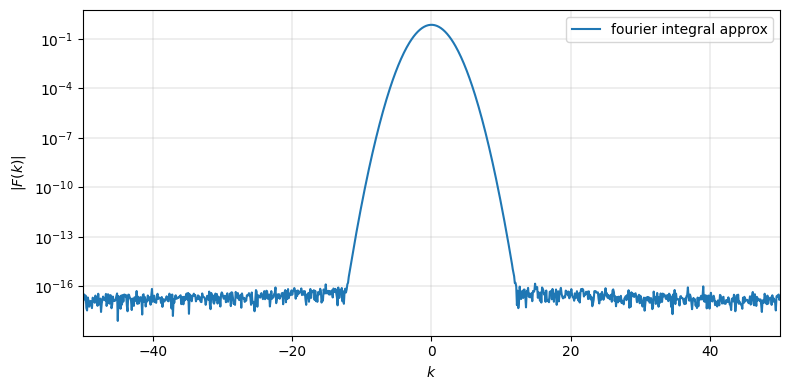

In [27]:

N, D = 10_000, 10
data = np.random.normal(size=(N, D))

x = data.ravel()         

x=np.linspace(-10, 10, N*D)  # sample points
f_x = np.exp(-x**2) / np.sqrt(2*np.pi) # gaussian

k, Fk = Fourier_transform(x, f_x, num_modes=1000)

plt.figure(figsize=(8, 4))
plt.semilogy(k, np.abs(Fk), label="fourier integral approx")
# plt.plot(k, np.exp(-(np.pi*k)**2) )
plt.xlabel(r"$k$")
plt.ylabel(r"$|F(k)|$")
plt.grid(True, which="both", linewidth=0.3)
plt.tight_layout()
plt.xlim(-50, 50)
plt.legend()
plt.show()

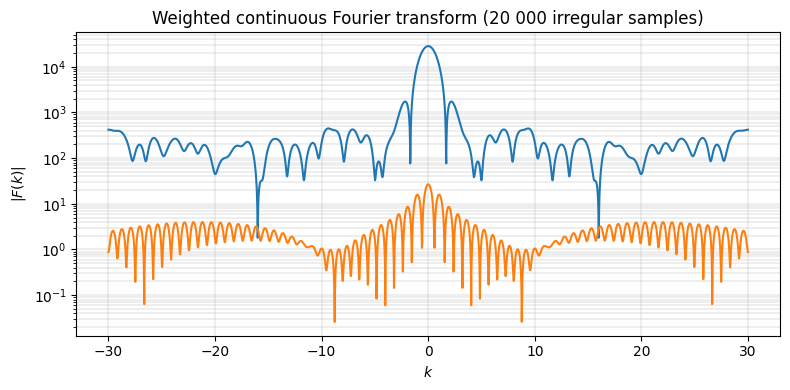

In [46]:
import numpy as np
import matplotlib.pyplot as plt

# ---------- synthetic data (same as before) ---------- #
N, D = 100_000, 10
sig = np.random.normal(size=(N, D))
bg  = np.random.normal(size=(N, D))
data = np.vstack([sig, bg])

x = data.ravel()                               # 2,000,000 irregular points
f = (-0.5 * x**2 - 0.5 * np.log(2*np.pi))      # analytic log-density

# ---------- random subset to keep demo light ---------- #
rng = np.random.default_rng(42)
subset_idx = rng.choice(len(x), size=20_000, replace=False)
x_sub = x[subset_idx]
f_sub = f[subset_idx]

# ---------- Voronoi / trapezoidal weights on the subset ---------- #
idx          = np.argsort(x_sub)
x_sorted     = x_sub[idx]
w_sorted     = np.empty_like(x_sorted)

w_sorted[1:-1] = 0.5 * (x_sorted[2:] - x_sorted[:-2])
w_sorted[0]    = 0.5 * (x_sorted[1]  - x_sorted[0])
w_sorted[-1]   = 0.5 * (x_sorted[-1] - x_sorted[-2])

# unsort so each weight matches the original ordering of x_sub
w_sub = np.empty_like(w_sorted)
w_sub[idx] = w_sorted

# ---------- brute-force continuous FT on a modest k-grid ---------- #
# ---------- brute-force Fourier series on a modest k-grid ---------- #
k = np.linspace(-30, 30, 3000)             # uniform k-grid
Fk_weighted = np.zeros_like(k, dtype=np.complex128)

phase = np.exp(-1j * x_sub[:, None] * k[None, :])  # (20k × 1025) matrix
Fk_weighted = (f_sub * w_sub) @ phase              # vectorised dot-product

# ---------- plot ---------- #
plt.figure(figsize=(8, 4))
plt.semilogy(k, np.abs(Fk))
plt.semilogy(k, np.abs(Fk_weighted))
plt.xlabel(r"$k$")
plt.ylabel(r"$|F(k)|$")
plt.title("Weighted continuous Fourier transform (20 000 irregular samples)")
plt.grid(True, which="both", linewidth=0.3)
plt.tight_layout()
plt.show()
